## INTRO & GOAL

in this notebook, I plan to check how the model performs when both X1 and X2 have high frequency. previously when X2 had high frequency, it failed to properly predict changes. X2 had a higher frequency by (c = 10). however, since we cannot directly change X1's frequency, we must change the forcing to get a higher frequency.

I played around in Prof. K's general Lorenz96 notebook. I looked for a F value that was reasonable, and gave us a higher general frequency than F=8. I settled on using F=20. However, it's important to note that because we are using F = 20, we are NO LONGER simulating the atmosphere, since the atmosphere is best modeled by F = 8 and K = 36. this is just a test to see if the X2 variable is only performing poorly when it has high frequency, or the GNN as a whole is performing poorly under high frequency.

TL;DR: i will be changing F = 8 to F = 20 to see how the model performs with high frequency. every other config parameter will stay constant from previous runs :)

## SETTING UP

In [2]:
%load_ext autoreload   
%autoreload 2

from utils.jraph_data import get_lorenz_graph_tuples, print_graph_fts
from utils.lorenz import load_lorenz96_2coupled

import numpy as np
import jax.numpy as jnp

In [3]:
from utils.jraph_training import train_and_evaluate_with_data, create_dataset, evaluate_model, rollout
# from utils.jraph_models import MLPGraphNetwork
from utils.jraph_data import print_graph_fts
from utils.jraph_vis import plot_predictions
from utils.hyperparam_tuning import remove_bad_trials, get_best_trial_config, get_best_trial_workdir
import ml_collections
import optuna 
from flax import linen as nn
from functools import partial
from datetime import datetime
import os 
import tempfile
import matplotlib.pyplot as plt 
import numpy as np 

import jax
from utils.jraph_training import create_dataset, create_model, create_optimizer
from clu import checkpoint
from clu import parameter_overview
from flax.training import train_state


/Users/miamirabelli/Desktop/GNN Research/lorenzGNN/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# set up logging
import logging
logger = logging.getLogger()
logger.setLevel(logging.WARNING)

## CONFIGS

In [5]:
def get_data_config():
    config = ml_collections.ConfigDict()

    config.n_samples=10_000
    config.input_steps=1
    config.output_delay=8 # predict 24 hrs into the future 
    config.output_steps=4
    config.timestep_duration=3 # equivalent to 3 hours
    # note a 3 hour timestep resolution would be 5*24/3=40
    # if the time_resolution is 120, then a sampling frequency of 3 would achieve a 3 hour timestep 
    config.sample_buffer = -1 * (config.input_steps + config.output_delay + config.output_steps - 1) # negative buffer so that our sample input are continuous (i.e. the first sample would overlap a bit with consecutive samples) 
        # number of timesteps strictly between the end 
        # of one full sample and the start of the next sample
    config.time_resolution=120 # the number of 
                # raw data points generated per time unit, equivalent to the 
                # number of data points generated per 5 days in the simulation
    config.init_buffer_samples=100
    config.train_pct=0.7
    config.val_pct=0.2
    config.test_pct=0.1
    config.K=36
    config.F=20
    config.c=1
    config.b=1
    config.h=1
    config.seed=42
    config.normalize=True
    config.fully_connected_edges=False

    return config

# create config 
config = get_data_config()
config.max_checkpts_to_keep = None # None means keep all

# Optimizer.
config.optimizer = "adam"
config.learning_rate = 0.0004

# Data params that are used in training 
config.output_steps = 4

# Training hyperparameters.
config.batch_size = 1 # variable currently not used
config.epochs = 200
config.log_every_epochs = 5
config.eval_every_epochs = 5
config.checkpoint_every_epochs = 5

# GNN hyperparameters.
config.model = 'MLPBlock'
config.dropout_rate = 2e-5
config.skip_connections = False # This was throwing a broadcast error in add_graphs_tuples_nodes when this was set to True
config.layer_norm = False # TODO perhaps we want to turn on later
config.activation = "leaky_relu"

config.pred_x1 = True
config.pred_x2 = True

if config.pred_x1 and config.pred_x2:
    output_layer = 2
else:
    output_layer = 1

# choose the hidden layer feature size using powers of 2 
config.edge_features = (
    2**2,
    2**2,
)
config.node_features = (
    2**8,
    2**3,
    output_layer,
)
# note the last feature size will be the number of features that the graph predicts
config.global_features = None



## DATA & LOGGING

In [6]:
# generate dataset 
forcing_increased = create_dataset(config)
print_graph_fts(forcing_increased['train']['inputs'][0][0])


Number of nodes: 36
Number of edges: 180
Node features shape: (36, 2)
Edge features shape: (180, 1)
Global features shape: (1, 1)


In [7]:
logger.setLevel(logging.INFO)

## TRAINING

In [8]:
# generate a workdir 
workdir="experiments/outputs/increasing_forcing"
#workdir = tempfile.mkdtemp()

# run training 
state, train_metrics, eval_metrics_dict = train_and_evaluate_with_data(config=config, workdir=workdir, datasets=forcing_increased)

INFO:absl:Hyperparameters: {'F': 20, 'K': 36, 'activation': 'leaky_relu', 'b': 1, 'batch_size': 1, 'c': 1, 'checkpoint_every_epochs': 5, 'dropout_rate': 2e-05, 'edge_features': (4, 4), 'epochs': 200, 'eval_every_epochs': 5, 'fully_connected_edges': False, 'global_features': None, 'h': 1, 'init_buffer_samples': 100, 'input_steps': 1, 'layer_norm': False, 'learning_rate': 0.0004, 'log_every_epochs': 5, 'max_checkpts_to_keep': None, 'model': 'MLPBlock', 'n_samples': 10000, 'node_features': (256, 8, 2), 'normalize': True, 'optimizer': 'adam', 'output_delay': 8, 'output_steps': 4, 'pred_x1': True, 'pred_x2': True, 'sample_buffer': -12, 'seed': 42, 'skip_connections': False, 'test_pct': 0.1, 'time_resolution': 120, 'timestep_duration': 3, 'train_pct': 0.7, 'val_pct': 0.2}
INFO:absl:Initializing network.
INFO:absl:
+-----------------------------+-----------+-------+----------+-------+
| Name                        | Shape     | Size  | Mean     | Std   |
+-----------------------------+-------

## PLOTTING

INFO:root:Initializing network.


Checkpoint directory: experiments/outputs/increasing_forcing/checkpoints


INFO:absl:
+-----------------------------+-----------+-------+----------+-------+
| Name                        | Shape     | Size  | Mean     | Std   |
+-----------------------------+-----------+-------+----------+-------+
| params/MLP_0/Dense_0/bias   | (4,)      | 4     | 0.0      | 0.0   |
| params/MLP_0/Dense_0/kernel | (6, 4)    | 24    | -0.058   | 0.351 |
| params/MLP_0/Dense_1/bias   | (4,)      | 4     | 0.0      | 0.0   |
| params/MLP_0/Dense_1/kernel | (4, 4)    | 16    | 0.0556   | 0.457 |
| params/MLP_1/Dense_0/bias   | (256,)    | 256   | 0.0      | 0.0   |
| params/MLP_1/Dense_0/kernel | (11, 256) | 2,816 | -0.00268 | 0.313 |
| params/MLP_1/Dense_1/bias   | (8,)      | 8     | 0.0      | 0.0   |
| params/MLP_1/Dense_1/kernel | (256, 8)  | 2,048 | 0.00112  | 0.063 |
| params/MLP_1/Dense_2/bias   | (2,)      | 2     | 0.0      | 0.0   |
| params/MLP_1/Dense_2/kernel | (8, 2)    | 16    | -0.277   | 0.26  |
+-----------------------------+-----------+-------+----------+----

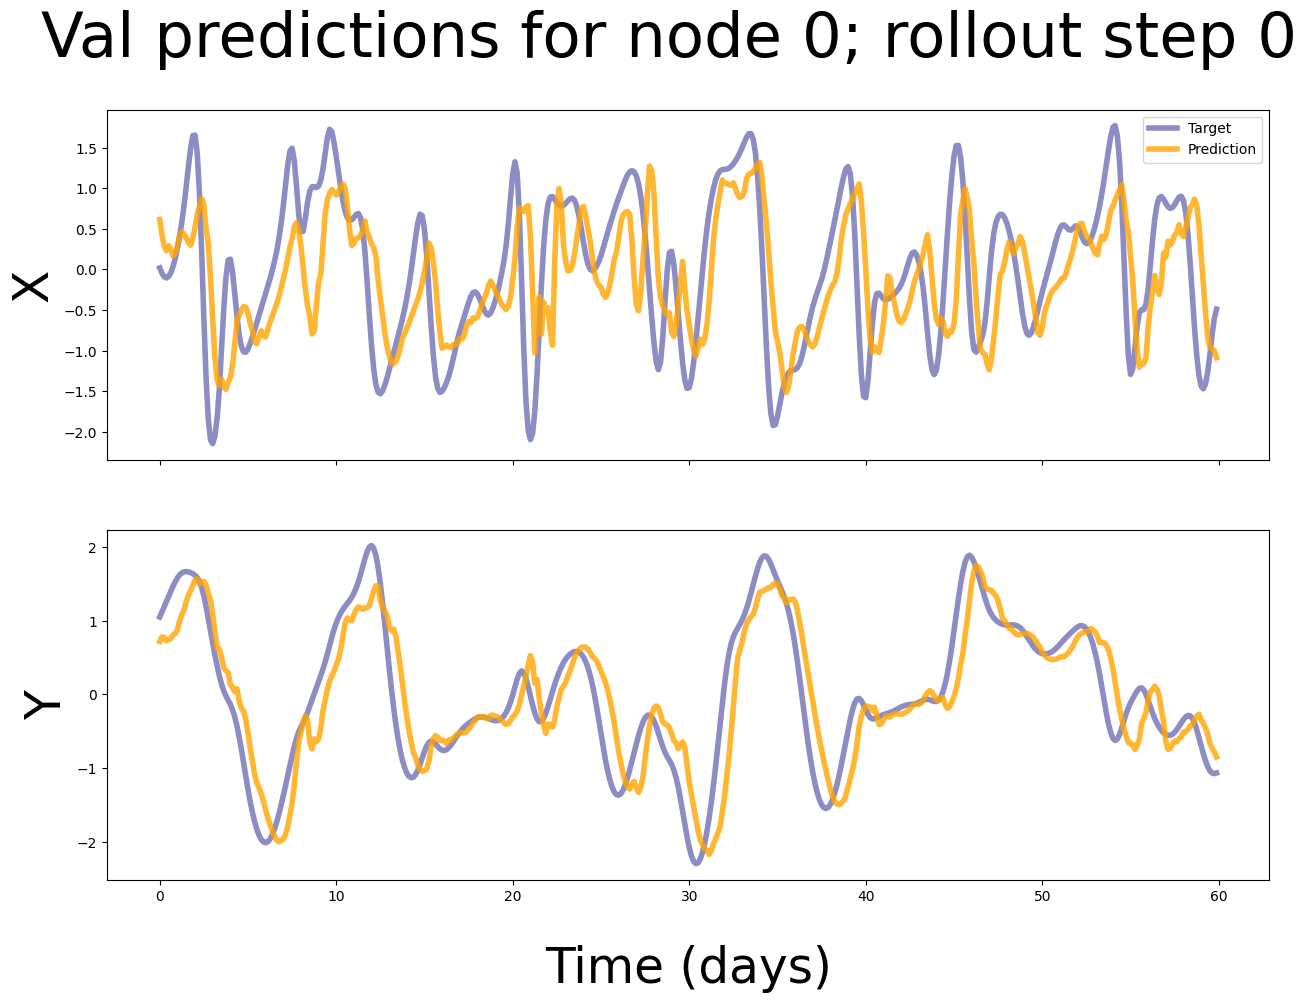

In [9]:
plot_predictions(
    config=config,
    workdir=workdir,
    plot_ith_rollout_step=0, # 0 indexed # for this study, we have a 4-step rollout 
    # dataset,
    # preds,
    # timestep_duration,
    # n_rollout_steps,
    #  total_steps,
    node=0, # 0-indexed 
    plot_mode="val", # i.e. "train"/"val"/"test"
    datasets=forcing_increased,
    plot_days=60, 
)

## THOUGHTS

ok this is interesting. When we increased the forcing here, X1 did not perform as well as X2. I would have assumed that neither would have performed well, but X2 is pretty consistent with the targets.

i can't tell if X2 performing better than X1 is because forcing primarily affects X1 or if its something else. will ask prof. K